In [13]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
#our processing code
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *

# used for motors
import asyncio
import math
import moteus

#used for GUI
%matplotlib notebook

# collect MSE from all the Trials
E_list = []

## Motor Functions

In [2]:
async def setup(stop_torque=.299,v=0.2,torque=0.3,test=False):
    """
    This function setup the motor to "zero":

    Args:
        stop_torque (float): the therhold torque that tells when the motor should stop.
        v (float): the verlocity for the motor to move in rad/s.
        torque (float): the maximum torque for the motor.

    Returns:
        float: the "zero" position in radians

    """
    print("begin setup")
    c = moteus.Controller()
    await c.set_stop()
    state = await c.set_position(position=math.nan, query=True)
    print("state info: ",state)
    print("Position:", state.values[moteus.Register.POSITION])
    print("Torque:", state.values[moteus.Register.TORQUE])
    print()
    await asyncio.sleep(0.02) # wait for the motor to change state
    while True:
        state = await c.set_position(position=math.nan, velocity = v, maximum_torque= torque,query=True)
        #print("Position:", state.values[moteus.Register.POSITION])
        #print("Torque:", state.values[moteus.Register.TORQUE])
        #print()
        await asyncio.sleep(0.001) # wait for spped command to reach the motor 
        if state.values[moteus.Register.TORQUE] > stop_torque:
            #print("Position:", state.values[moteus.Register.POSITION])
            #print("Torque:", state.values[moteus.Register.TORQUE])
            await c.set_stop()
            print("motor is ready")
            p = state.values[moteus.Register.POSITION]*(2*math.pi)
            break
    if test:
        for x in range(500):
            await c.set_position(position=math.nan, velocity = -v, maximum_torque= torque,query=True)
    print("Initial Starting Degree: ","{:.2f}".format(180/p))
    return p

In [3]:
async def one_axis_test(intial_position,stop_torque=.299,v=0.2,torque=0.3):
    """
    This function runs the motor farward and backward:

    Args:

    Returns:

    """
    p = intial_position/(2*math.pi)
    p_list = []
    
    print("Begain Testing")
    c = moteus.Controller()
    for x in range(1000):
        state = await c.set_position(position=math.nan+p, velocity = -v, maximum_torque=torque, query=True)
        await asyncio.sleep(0.001)
        if state.values[moteus.Register.TORQUE] > stop_torque:
            print("stoped")
            p_list.append(state.values[moteus.Register.POSITION]*(2*math.pi))
            break
    print("car coming back")
    for x in range(1000):
        state = await c.set_position(position=math.nan+p, velocity = v, maximum_torque=torque, query=True)
        await asyncio.sleep(0.001)
        if state.values[moteus.Register.TORQUE] > stop_torque:
            print("stoped")
            break
    await c.set_stop()
    print("Finish")
    return p_list

## Setup the Motor

#### Run the code below to check the motor each Test

In [4]:
async def stopping_acc_test(n_loop):
    position_setpoint_list = []
    save_time = []
    for i in range(n_loop):
        position_setpoint_list.append(180/(await setup(test=True)))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(position_setpoint_list)
    ax.set_title('Stopping Accuracy Test Plot')
    ax.set_ylabel('degree')
    plt.show()

Enter the number of loop10
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 8.880844116210938, VELOCITY(0x002): -0.01680927723646164, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 24.0, FAULT(0x00f): 0}
Position: 8.880844116210938
Torque: 0.0

motor is ready
Initial Starting Degree:  3.12
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 8.842803955078125, VELOCITY(0x002): -0.15115080773830414, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 24.0, FAULT(0x00f): 0}
Position: 8.842803955078125
Torque: 0.0

motor is ready
Initial Starting Degree:  3.12
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 8.919876098632812, VELOCITY(0x002): -0.3276505470275879, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 25.0, FAULT(0x00f): 0}
Position: 8.919876098632812
Torque: 0.0

motor is ready
Initial Starting Degree:  3.12
begin setup
state info:  1/{MODE(0x000): 0, POSITION(0x001): 8.888290405273438, VELOCITY(0x002): -0.3

<IPython.core.display.Javascript object>


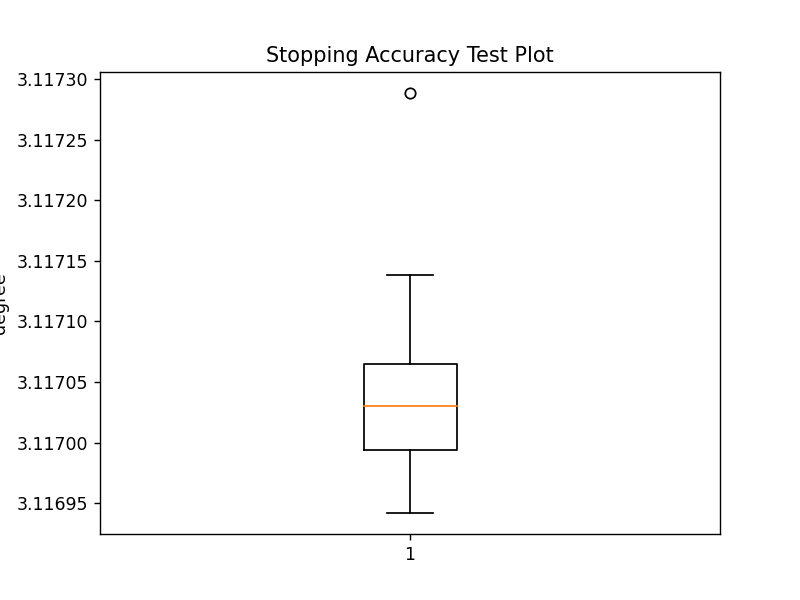

In [5]:
n = input('Enter the number of loop')
await stopping_acc_test(int(n))

## Let's Start the Test

### First, zero the motor and save the initial position(radian,shows in degree)

In [ ]:
input('Press Enter to Start the Test')
ip = await setup()
print("Initial Starting Radian: ", ip)

### Once get the intial starting postion, run the 1-axis testing function with the desired postion, and then run the CT scanner

In [ ]:
data_list = []
currcent_p_list = []
currcent_p_list.append(await one_axis_test(intial_position=ip))

### Plot the result

#### python -m moteus_gui.tview --devices=1

## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM file folder ONLY to the following folder: ./test_data

## Processing DICOM file

### Enter the DICOM folder name that contians the files

In [6]:
scan_file = './test_data/'
name = input('Enter the name of the DICOM folder: ')
scan_file = scan_file+name
print("New scan file name: ",scan_file)

Enter the name of the DICOM folder: biopsy 2
New scan file name:  ./test_data/biopsy 2


### Pick target marker postion(1 or 2)

In [7]:
#choose target marker
name = input('Enter the targert marker postion, please enter 1 or 2: ')
if int(name) == 1:
    target_marker = 'marker1'
elif int(name) == 2:
    target_marker = 'marker2'
print("You have choose the target marker: ",target_marker)

Enter the targert marker postion, please enter 1 or 2: 2
You have choose the target marker:  marker2


### Convert DICOM files

In [8]:
#convert scan to mesh for finding markers via thresholding
# !!! comment the below code to change the way file is loaded !!!
#convert_scan_to_mesh(scan_file='./test_data/bb_marker3.pkl')
#convert_scan_to_mesh_mha(scan_file='./test_data/biopsy 2')
convert_scan_to_mesh_mha(scan_file)

spacing:  [1.25     0.976563 0.976563]
image_stack shape:  (37, 512, 512)


### Disaply DICOM file (Left and Right are the SAME)

origin: (-250.0, -250.0, -167.5)
size: (512, 512, 37)
spacing: (0.976563, 0.976563, 1.25)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-250.0, -250.0, -167.5)
size: (512, 512, 37)
spacing: (0.976563, 0.976563, 1.25)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1



<IPython.core.display.Javascript object>


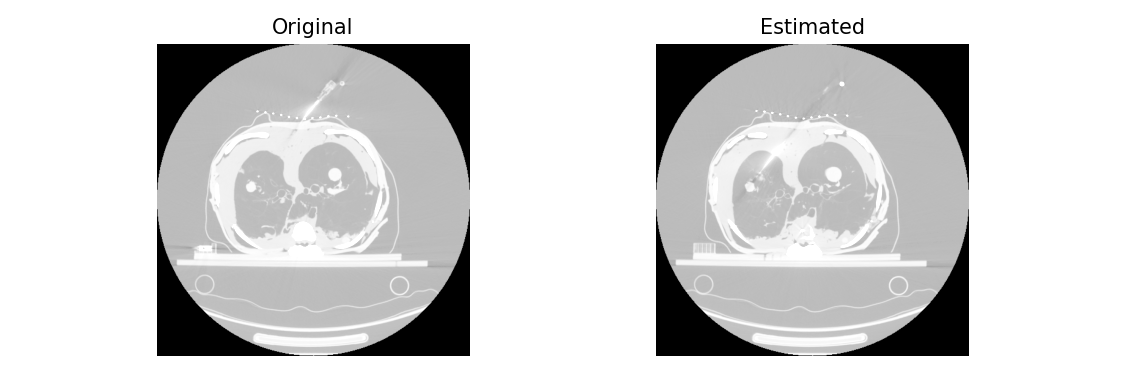

In [9]:
display_Dicom("temp_mesh.mha","temp_mesh.mha")

### Once the Imag above looks right, run the following code the find the neede error and transform

In [10]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
marker, marker_centroid_coordinates, pcd_selected, mesh, coordinate_frame, good_centroid_clusters = find_candidate_centroids(target_marker = target_marker)

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, mesh])
print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#find best transform and marker from candidate fiducials
final_R, final_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 33


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]C:\Users\derek\ECE\CT Research\ct-fiducial-tracking-main\ct_tracking_library\ct_tracking_functions.py:376: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residules, rank, singval = np.linalg.lstsq(A,f)
100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 235.60it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
point cloud has 1 clusters
[0 1 2 3]
Multiple good clusters/centroids found
marker centroid coordinates from design: [[  0.           0.           0.        ]
 [-25.17330897   0.27807421  -0.31303004]
 [ -0.13682961  -1.03970283 -10.9369699 ]
 [-12.25998655  -1.57713288 -23.71379929]]
found centroid coordinates: [ 22.73992407  64.98866488 296.60012308]
[0.06427626]
Everything looks good!
the final error is:  0.06427626125538671


In [12]:
#display tracked  markers and coordinate frames
marker = np.load('./test_data/'+target_marker+'.npy')
marker_3d_base, marker_3d_transformed, err = visualize_tracked_marker(marker, final_R, final_t, permuted_centroids)
o3d.visualization.draw_geometries(marker_3d_base+marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print(err)
print("ERROR: ",np.linalg.norm(err))

#visualize everything at once
visualization_list = [pcd_selected, mesh]+marker_3d_base+marker_3d_transformed
o3d.visualization.draw_geometries(visualization_list)

[[ 0.04 -0.04 -0.03]
 [-0.06  0.02  0.04]
 [ 0.06 -0.01  0.01]
 [-0.04  0.03 -0.02]]
ERROR:  0.12855252251077343


In [14]:
E_list.append(np.linalg.norm(err))

## Once Finished ALL 5 trials, plot the err

<IPython.core.display.Javascript object>


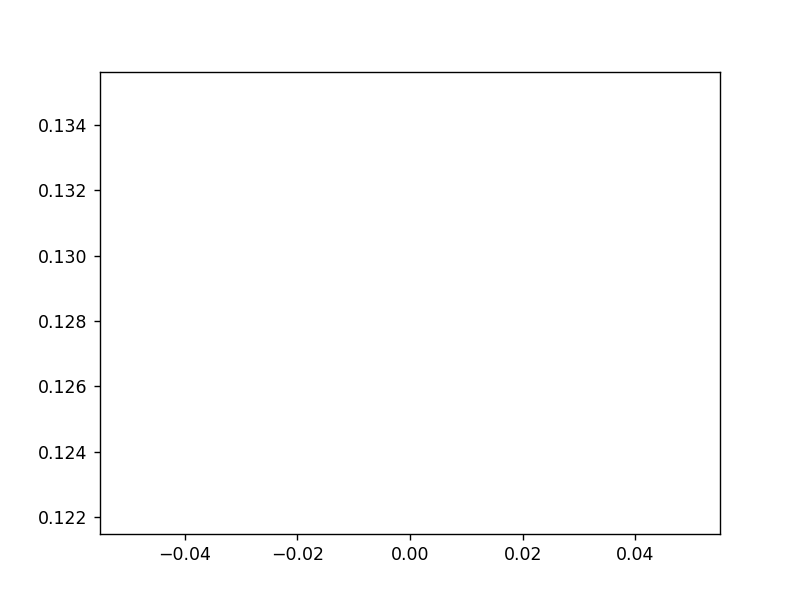

In [15]:
plt.plot(E_list)